In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
def sinkhorn(C, eps=1, n_iters=100):
    P = torch.exp(-C / eps)
    for _ in range(n_iters):
        P = P / (P.sum(dim=-1, keepdim=True) + 1e-8)
        P = P / (P.sum(dim=-2, keepdim=True) + 1e-8)
    return P

def rml_loss_flux_matching(x0_population: torch.Tensor, 
                           output_population: torch.Tensor,
                           strict_matching=False):
    x0_flux = x0_population.detach()[:, :, :, -1].unsqueeze(-1)  # (b, m, max_objects, 1)
    output_flux = output_population.detach()[:, :, :, -1].unsqueeze(-2)  # (b, m, 1, max_objects)
    cost_matrix = (x0_flux - output_flux).abs()  # (b, m, max_objects, max_objects)
    if strict_matching:
        assign_m = []
        for cm in cost_matrix.flatten(0, 1):
            _ri, ci = linear_sum_assignment(cm.cpu().numpy())
            assign_m.append(torch.from_numpy(ci))
        assign_m = repeat(torch.stack(assign_m, dim=0), 
                        "(b m) max_objects -> b m max_objects k", 
                        b=output_population.shape[0], 
                        m=output_population.shape[1],
                        k=output_population.shape[-1]).to(device=output_population.device)
    else:
        assign_p = sinkhorn(cost_matrix)
        assign_m = repeat(assign_p.argmax(dim=-1), 
                          "b m max_objects -> b m max_objects k", 
                          k=output_population.shape[-1])
    return torch.gather(output_population, dim=-2, index=assign_m)

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(hidden_dim, 
                                          num_heads=num_heads, 
                                          batch_first=True)

    def forward(self, x):
        return self.attn(x, x, x)[0]


class FourierTransformer(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        assert len(data_shape) == 2  # (m, k)

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
        )
        self.input_embed = nn.Sequential(
            nn.Linear(data_shape[-1], hidden_ch),
            nn.GELU(),
        )
        self.image_embed = nn.Sequential(
            nn.Conv2d(1, hidden_ch // 4, kernel_size=(2, 2), padding=0, stride=2),  # 4
            nn.GELU(),
            nn.Conv2d(hidden_ch // 4, hidden_ch // 2, kernel_size=(2, 2), padding=0, stride=2),  # 2
            nn.GELU(),
            nn.Conv2d(hidden_ch // 2, hidden_ch, kernel_size=(2, 2), padding=0, stride=2),  # 2
            nn.GELU(),
            nn.Flatten(1),
            nn.Linear(hidden_ch, hidden_ch),
            nn.GELU()

        )
        self.integrate_layer = nn.Sequential(
            nn.Linear(hidden_ch * 2 + data_shape[-1], hidden_ch),
            nn.GELU(),
        )
        self.layers = nn.ModuleList(
            [
                nn.ModuleList(
                    [SelfAttention(hidden_ch, 4), nn.LayerNorm(hidden_ch)]
                ) for _ in range(num_layers)
            ]
        )
        self.output_layer = nn.Linear(hidden_ch, data_shape[-1])
        self.vmap_layers = torch.vmap(self.layers_forward, in_dims=1, out_dims=1)

    def layers_forward(self, x):
        for attn, ln in self.layers:
            x = attn(x) + x
            x = ln(x)
        return x

    def forward(self, x, t, image, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m 1 (d w)")
            )  # (b, m, 1, hidden)
            embed_xt = self.input_embed(x)  # (b, m, max_objects, hidden)
            embed_image = self.image_embed(image.unsqueeze(1))  # (b, hidden)
            embed_image = repeat(embed_image, 
                                 "b hidden -> b m max_objects hidden", 
                                 m=embed_xt.shape[1], 
                                 max_objects=embed_xt.shape[2])
            out = self.vmap_layers(
                self.integrate_layer(
                    torch.cat([embed_xt + embed_t, embed_image, epsilon], dim=-1)
                )
            )
            out = self.output_layer(out)
            assert out.shape == x.shape
            return out
        
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b 1 (d w)")
        )
        embed_xt = self.input_embed(x)
        embed_image = self.image_embed(image.unsqueeze(1))
        embed_image = repeat(embed_image,
                             "b hidden -> b max_objects hidden",
                             max_objects=embed_xt.shape[1])
        out = self.layers_forward(
            self.integrate_layer(
                    torch.cat([embed_xt + embed_t, embed_image, epsilon], dim=-1)
            )
        )
        out = self.output_layer(out)
        assert out.shape == x.shape
        return out

In [6]:
# class FourierMLP(nn.Module):
#     def __init__(self, data_shape, num_layers, hidden_ch):
#         super().__init__()
#         self.data_shape = [data_shape]

#         self.register_buffer(
#             "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
#         )  # (1, hidden)
#         self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
#         self.input_embed = nn.Sequential(
#             nn.Linear(int(np.prod(data_shape)), hidden_ch),
#             nn.GELU(),
#             nn.Linear(hidden_ch, hidden_ch)
#         )
#         self.timestep_embed = nn.Sequential(
#             nn.Linear(2 * hidden_ch, hidden_ch),
#             nn.GELU(),
#             nn.Linear(hidden_ch, hidden_ch),
#         )
#         self.image_embed = nn.Sequential(
#             nn.Linear(image_size * image_size, hidden_ch),
#             nn.GELU(),
#             nn.Linear(hidden_ch, hidden_ch)
#         )
#         self.layers = nn.Sequential(
#             nn.Linear(hidden_ch * 2 + int(np.prod(data_shape)), hidden_ch), 
#             nn.GELU(),
#             *[
#                 nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
#                 for _ in range(num_layers)
#             ],
#             nn.Linear(hidden_ch, int(np.prod(data_shape))),
#         )

#         self.vmap_timestep_embed = torch.vmap(self.timestep_embed.forward, in_dims=1, out_dims=1, randomness="same")
#         self.vmap_input_embed = torch.vmap(self.input_embed.forward, in_dims=1, out_dims=1, randomness="same")
#         self.vmap_layers = torch.vmap(self.layers.forward, in_dims=1, out_dims=1, randomness="same")

#     def forward(self, x, t, image, epsilon, is_training):
#         if is_training:
#             t = t.unsqueeze(-1)  # (b, m, 1)
#             sin_embed_t = torch.sin(
#                 (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
#             )
#             cos_embed_t = torch.cos(
#                 (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
#             )
#             embed_t = self.vmap_timestep_embed(
#                 rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
#                           "d b m w -> b m (d w)")
#             )  # (b, m, hidden)
#             embed_xt = self.vmap_input_embed(x.flatten(2))  # (b, m, hidden)
#             embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
#             embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
#             out = self.vmap_layers(
#                 torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(2)], dim=-1)
#             )
#             return out.view(x.shape)
#         t = t.clone()
#         image = image.clone()
#         t = t.unsqueeze(-1)  # (b, 1)
#         sin_embed_t = torch.sin(
#             (self.timestep_coeff * t.float()) + self.timestep_phase
#         )  # (b, hidden)
#         cos_embed_t = torch.cos(
#             (self.timestep_coeff * t.float()) + self.timestep_phase
#         )
#         embed_t = self.timestep_embed(
#             rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
#                       "d b w -> b (d w)")
#         )
#         embed_xt = self.input_embed(x.flatten(1))
#         embed_image = self.image_embed(image.flatten(1))
#         out = self.layers(
#             torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(1)], dim=-1)
#         )
#         return out.view(x.shape)

In [7]:
device = torch.device("cuda:7")
batch_size = 1024
training_time_steps = 1000
training_iters = 10_000
ddim_steps = 5
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [8]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

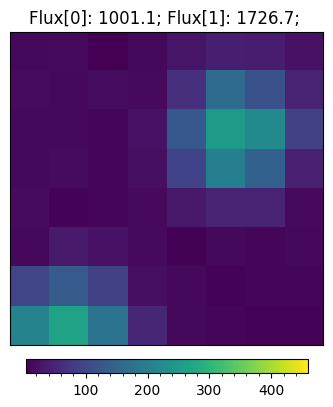

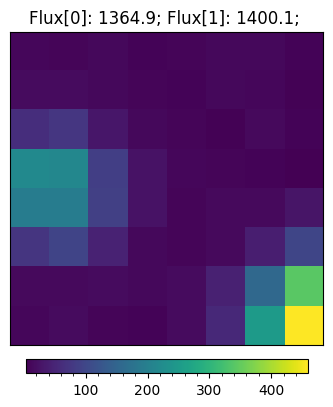

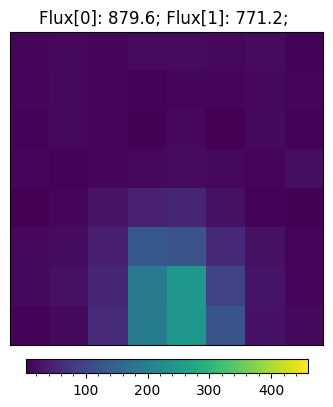

In [9]:
sim_out = image_simulator.generate(3, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [10]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=8,
                                  lambda_=1.0,
                                  beta=0.5,
                                  matching_fn=rml_loss_flux_matching)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)

In [11]:
my_net = FourierTransformer(data_shape=[2, 4], 
                            num_layers=4, 
                            hidden_ch=32).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [12]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [13]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (flux / max_flux_boundary) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [14]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    locs = catalog["locs"]  # (b, m, 2)
    fluxes = catalog["fluxes"].unsqueeze(-1)  # (b, m, 1)
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, locs.shape[1] + 1, device=locs.device)).unsqueeze(-1)  # (b, m, 1)
    x_start = torch.cat([n_sources * 2 - 1, locs / image_size * 2 - 1, encode_flux(fluxes)], dim=-1)  # (b, m, 4)
    sorted_index = x_start[..., -1].argsort(dim=-1, descending=True)  # (b, m)
    return torch.take_along_dim(x_start, repeat(sorted_index, "... -> ... r", r=4), dim=-2)  # (b, m, 4)

In [15]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    locs = (output_x_start[..., 1:3] + 1) / 2 * image_size  # (b, m, 2)
    fluxes = decode_flux(output_x_start[..., 3])  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
        "locs": locs,
        "fluxes": fluxes,
    }

In [16]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [17]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    train_loss_args = {
        "model": my_net,
        "x_start": encode_x_start(catalog),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  5%|▌         | 503/10000 [00:18<05:43, 27.67it/s]

[500/10000] loss: 1.487e-01


 10%|█         | 1004/10000 [00:36<05:21, 28.01it/s]

[1000/10000] loss: 1.356e-01


 15%|█▌        | 1505/10000 [00:54<05:32, 25.56it/s]

[1500/10000] loss: 1.271e-01


 20%|██        | 2003/10000 [01:11<04:45, 27.98it/s]

[2000/10000] loss: 1.277e-01


 25%|██▌       | 2504/10000 [01:29<04:31, 27.63it/s]

[2500/10000] loss: 1.162e-01


 30%|███       | 3005/10000 [01:47<04:08, 28.21it/s]

[3000/10000] loss: 1.209e-01


 35%|███▌      | 3503/10000 [02:05<03:50, 28.14it/s]

[3500/10000] loss: 1.224e-01


 40%|████      | 4004/10000 [02:23<03:39, 27.29it/s]

[4000/10000] loss: 1.133e-01


 45%|████▌     | 4505/10000 [02:41<03:15, 28.09it/s]

[4500/10000] loss: 1.157e-01


 50%|█████     | 5003/10000 [02:58<02:59, 27.84it/s]

[5000/10000] loss: 1.146e-01


 55%|█████▌    | 5504/10000 [03:16<02:39, 28.20it/s]

[5500/10000] loss: 1.139e-01


 60%|██████    | 6005/10000 [03:34<02:26, 27.35it/s]

[6000/10000] loss: 1.094e-01


 65%|██████▌   | 6503/10000 [03:52<02:07, 27.38it/s]

[6500/10000] loss: 1.113e-01


 70%|███████   | 7004/10000 [04:10<01:49, 27.46it/s]

[7000/10000] loss: 1.101e-01


 75%|███████▌  | 7504/10000 [04:28<01:29, 27.85it/s]

[7500/10000] loss: 1.016e-01


 80%|████████  | 8005/10000 [04:46<01:10, 28.18it/s]

[8000/10000] loss: 9.797e-02


 85%|████████▌ | 8503/10000 [05:03<00:53, 28.15it/s]

[8500/10000] loss: 1.112e-01


 90%|█████████ | 9004/10000 [05:21<00:35, 27.79it/s]

[9000/10000] loss: 9.549e-02


 95%|█████████▌| 9505/10000 [05:39<00:17, 28.04it/s]

[9500/10000] loss: 1.075e-01


100%|██████████| 10000/10000 [05:57<00:00, 27.99it/s]

[10000/10000] loss: 9.720e-02


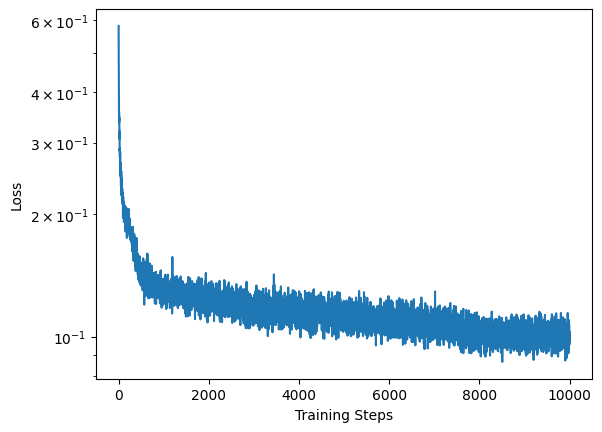

In [18]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [ ]:
my_net.eval()
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(1000))):
        val_catalog = image_simulator.generate(batch_size=1024)
        input_image = normalize_image(val_catalog["images"])
        val_catalog = decode_x_start(encode_x_start(val_catalog))
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1024, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_cat.append(move_data_to_device(decode_x_start(sample), "cpu"))

100%|██████████| 1000/1000 [00:17<00:00, 56.23it/s]


In [20]:
diffusion_pred_ns = []
diffusion_true_ns = []
diffusion_pred_locs = []
diffusion_true_locs = []
diffusion_pred_fluxes = []
diffusion_true_fluxes = []
for ec, tc in zip(val_est_cat, val_true_cat, strict=True):
    diffusion_pred_ns.append(ec["n_sources"])
    diffusion_true_ns.append(tc["n_sources"])
    diffusion_pred_locs.append(ec["locs"])
    diffusion_true_locs.append(tc["locs"])
    diffusion_pred_fluxes.append(ec["fluxes"])
    diffusion_true_fluxes.append(tc["fluxes"])
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)

In [21]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [22]:
diffusion_pred_locs.shape, diffusion_true_locs.shape

(torch.Size([1024000, 2, 2]), torch.Size([1024000, 2, 2]))

In [23]:
diffusion_pred_fluxes.shape, diffusion_true_fluxes.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [24]:
def plot_cm(d_pred_bin_index, d_true_bin_index, bin_num, bin_labels, axis_label):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion")
    fig.show()

    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
    #             annot=True,
    #             fmt=".2f", cmap="Greens", cbar=False,
    #             xticklabels=bin_labels,
    #             yticklabels=bin_labels,
    #             ax=ax)
    # ax.set_xlabel(f"True {axis_label}")
    # ax.set_ylabel(f"Pred {axis_label}")
    # ax.set_title("Diffusion (CM in Percent)")
    # fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
                annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion (Asymmetry Factor)")
    fig.show()

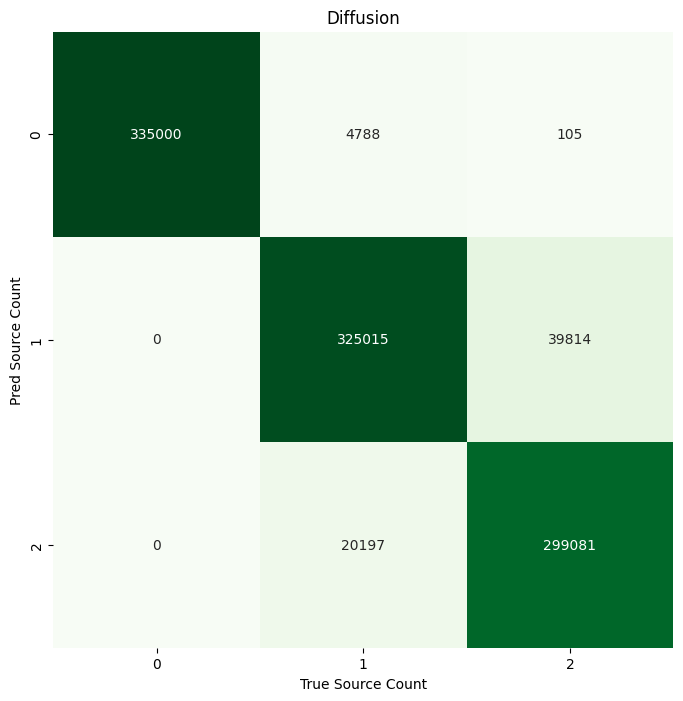

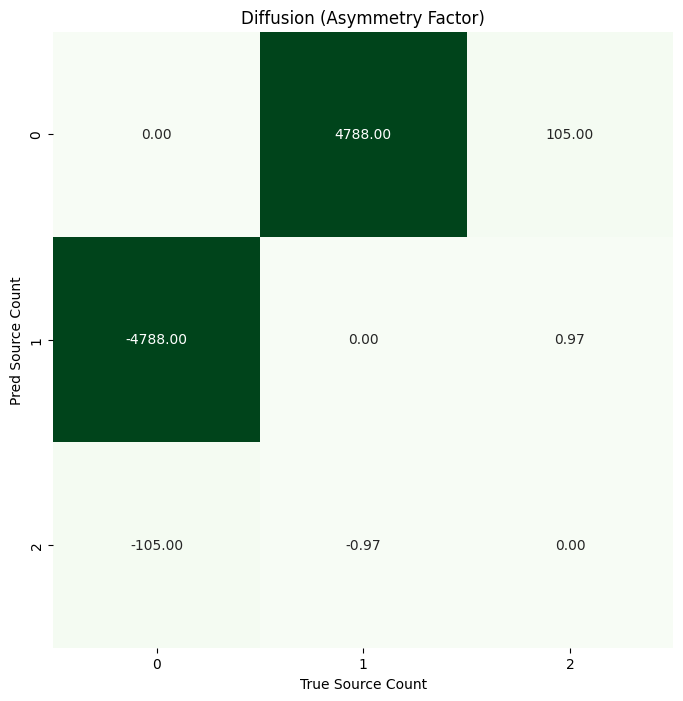

In [25]:
plot_cm(diffusion_pred_ns.sum(dim=-1), diffusion_true_ns.sum(dim=-1), 
        bin_num=3, bin_labels=list(range(3)), axis_label="Source Count")

In [26]:
def inclusive_bucektize(input_t, boundary):
    new_boundary = boundary.clone()
    new_boundary[0] -= 1e-3
    new_boundary[-1] += 1e-3
    b_index = torch.bucketize(input_t, new_boundary)
    assert (b_index > 0).all()
    assert (b_index < new_boundary.shape[0]).all()
    return b_index - 1

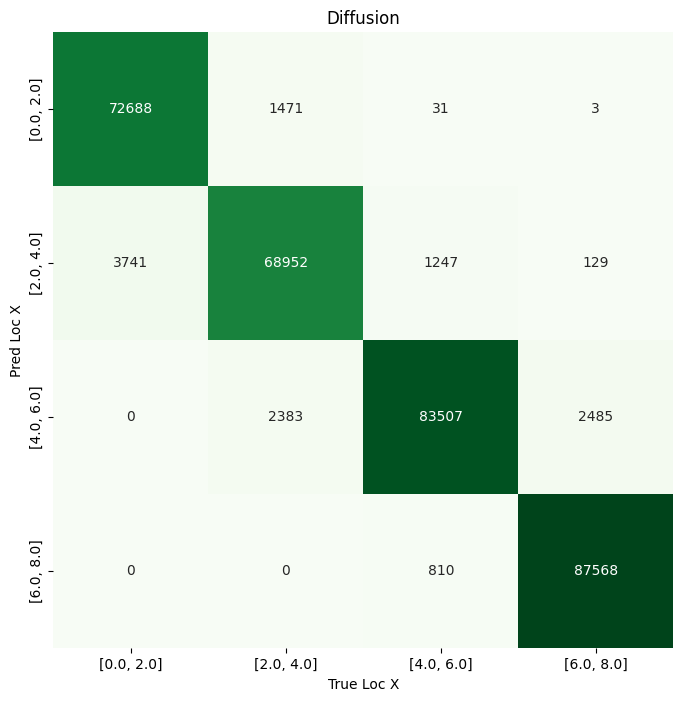

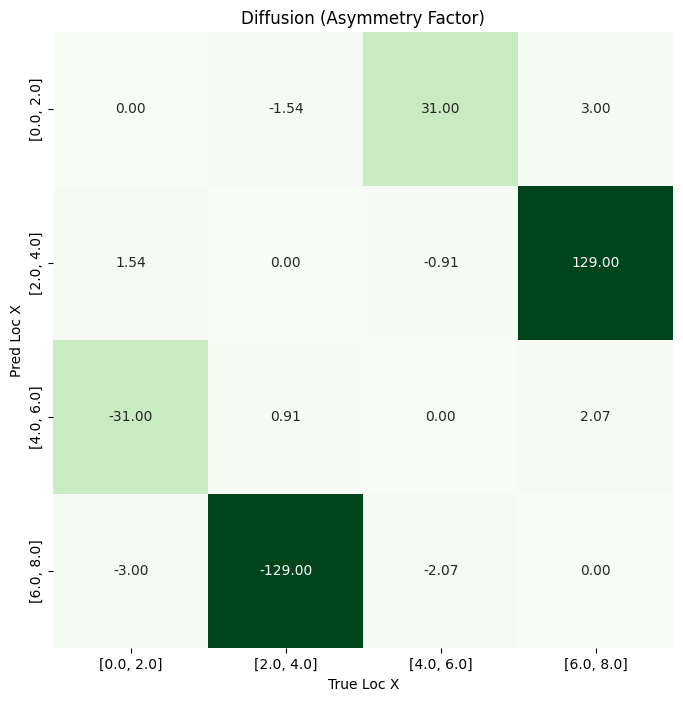

In [27]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
only_one_source_mask = ((diffusion_pred_ns.sum(dim=-1) == 1) & (diffusion_true_ns.sum(dim=-1) == 1)).unsqueeze(-1)  # (b, 1)
d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 1][only_one_source_mask & diffusion_pred_ns.bool()], 
                                              locs_bin_boundary)
d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[..., 1][only_one_source_mask & diffusion_true_ns.bool()], 
                                              locs_bin_boundary)
plot_cm(d_pred_locs_x_bin_index, d_true_locs_x_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc X")

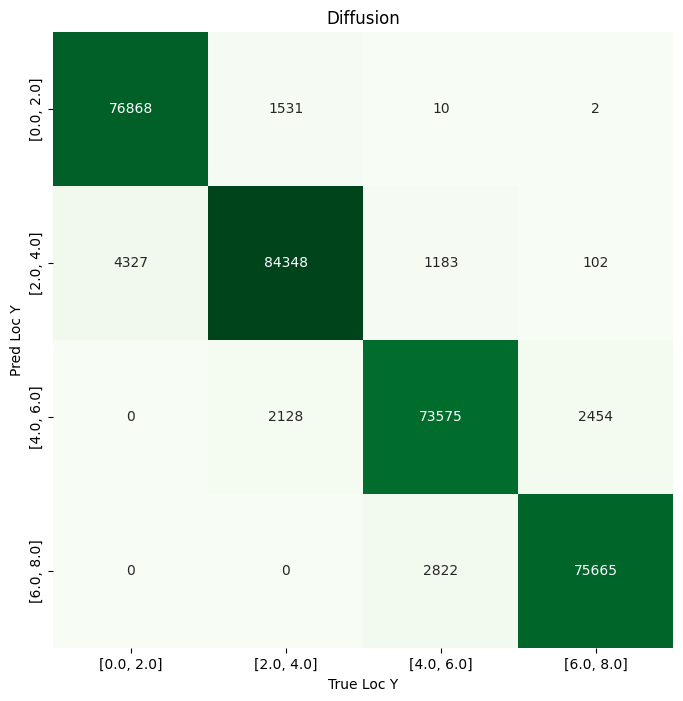

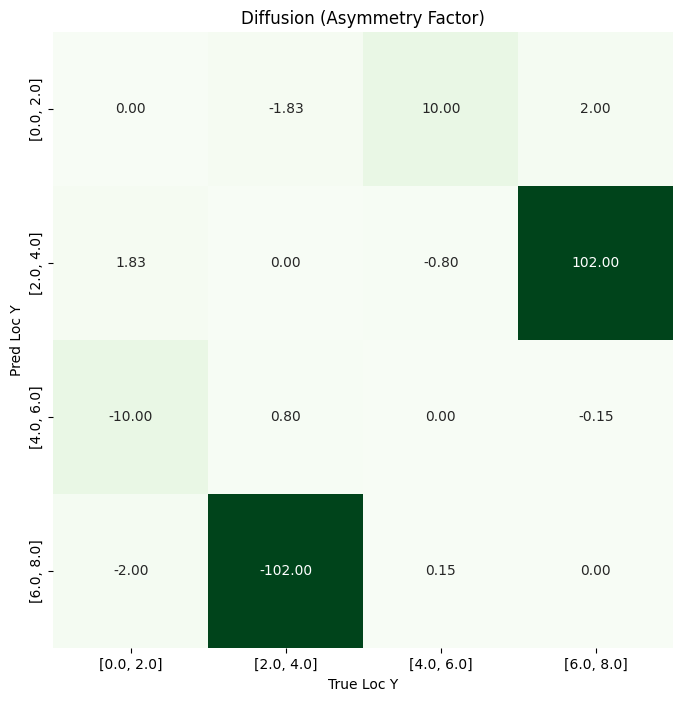

In [28]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
only_one_source_mask = ((diffusion_pred_ns.sum(dim=-1) == 1) & (diffusion_true_ns.sum(dim=-1) == 1)).unsqueeze(-1)
d_pred_locs_y_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 0][only_one_source_mask & diffusion_pred_ns.bool()], 
                                              locs_bin_boundary)
d_true_locs_y_bin_index = inclusive_bucektize(diffusion_true_locs[..., 0][only_one_source_mask & diffusion_true_ns.bool()], 
                                              locs_bin_boundary)
plot_cm(d_pred_locs_y_bin_index, d_true_locs_y_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc Y")

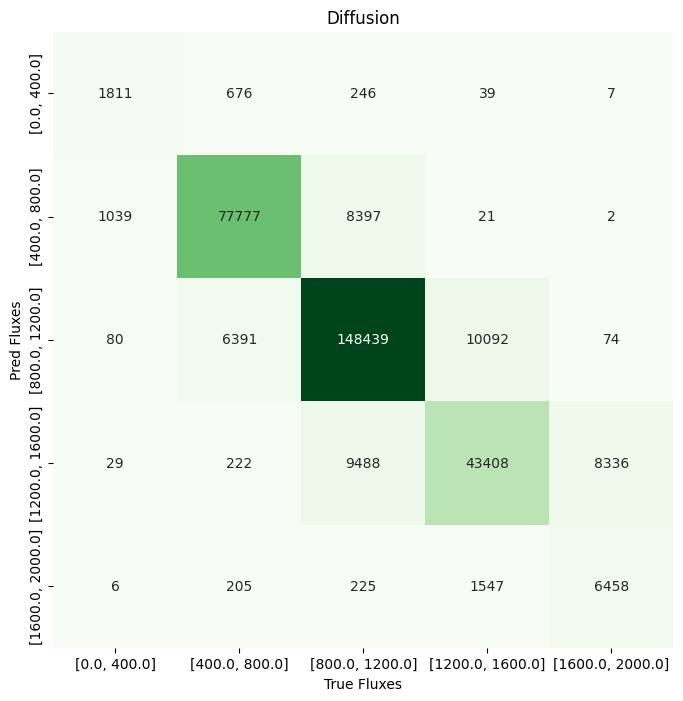

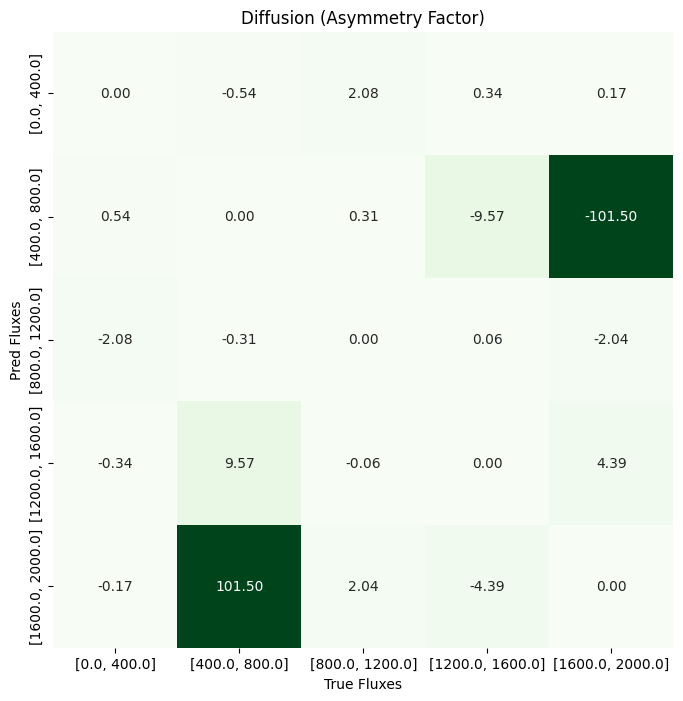

In [38]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
only_one_source_mask = ((diffusion_pred_ns.sum(dim=-1) == 1) & (diffusion_true_ns.sum(dim=-1) == 1)).unsqueeze(-1)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes[only_one_source_mask & diffusion_pred_ns.bool()], 
                                              fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes[only_one_source_mask & diffusion_true_ns.bool()], 
                                              fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")

In [30]:
my_cat = {
    "counts": torch.ones(1, device=device, dtype=torch.int) * 2,
    "locs": torch.tensor([[3.0, 3.0], [5.0, 5.0]], device=device).unsqueeze(0),
    "fluxes": torch.tensor([1000.0, 1500.0], device=device).unsqueeze(0)
}

In [31]:
my_cat = image_simulator._generate_by_catalog(my_cat)

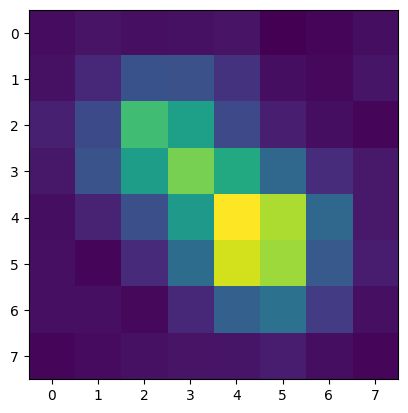

In [32]:
plt.imshow(my_cat["images"][0].cpu())
plt.show()

In [33]:
input_image = normalize_image(my_cat["images"])
traces = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(100))):
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        _sample, inter = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, 
                                                             eta=ddim_eta, 
                                                             return_intermediate=True)
        traces.append([decode_x_start(i) for i in inter])

100%|██████████| 100/100 [00:01<00:00, 70.63it/s]


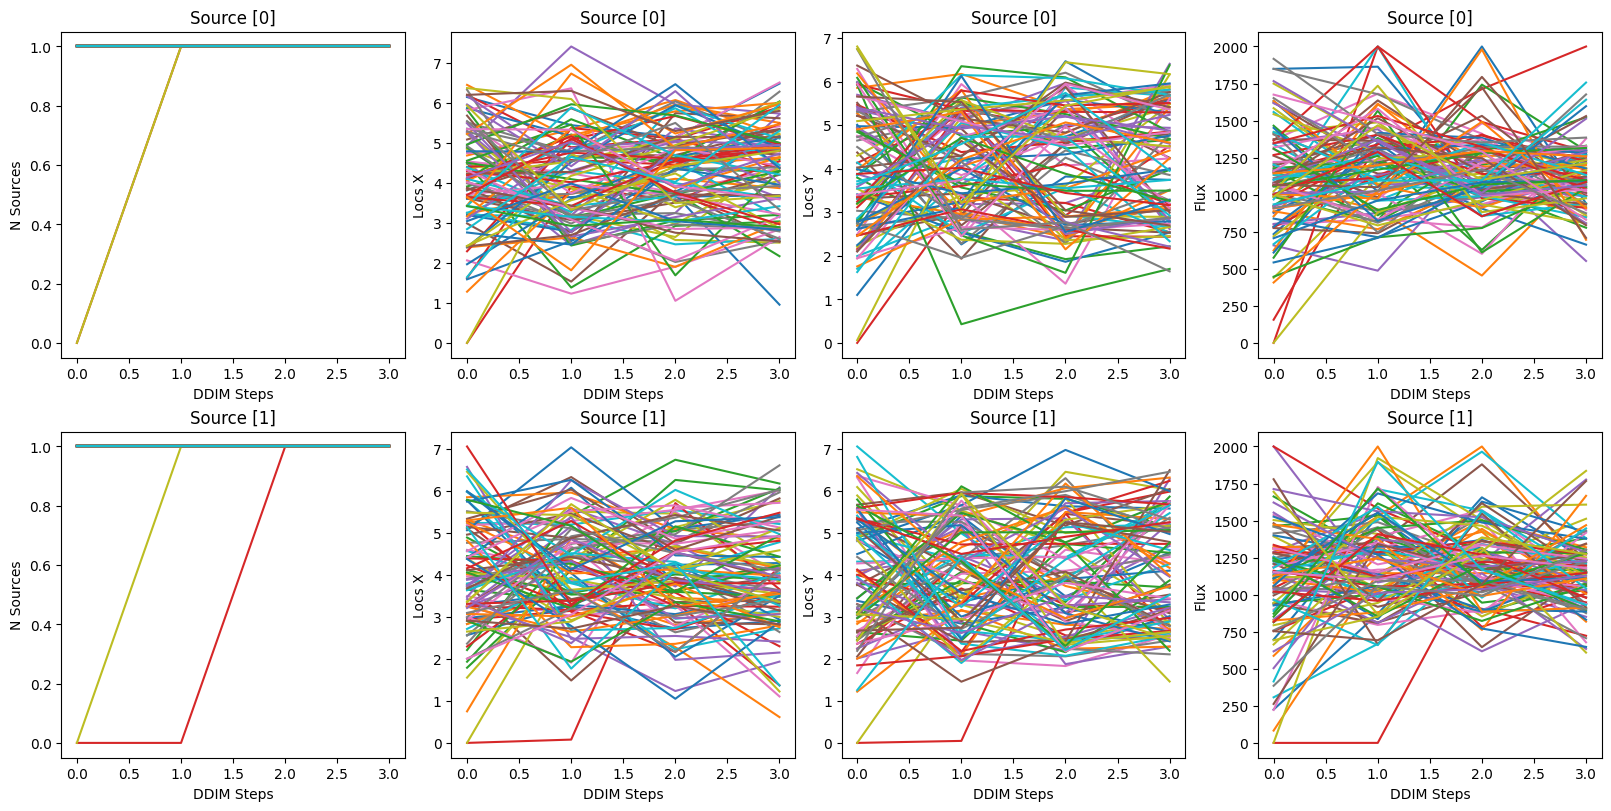

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
for t in traces:
    x = list(range(len(t)))
    for mi in range(2):
        axes[mi, 0].plot(x, [tt["n_sources"][0, mi].item() for tt in t])
        axes[mi, 0].set_ylabel("N Sources")
        axes[mi, 0].set_xlabel("DDIM Steps")
        axes[mi, 0].set_title(f"Source [{mi}]")
        axes[mi, 1].plot(x, [tt["locs"][0, mi, 1].item() for tt in t])
        axes[mi, 1].set_ylabel("Locs X")
        axes[mi, 1].set_xlabel("DDIM Steps")
        axes[mi, 1].set_title(f"Source [{mi}]")
        axes[mi, 2].plot(x, [tt["locs"][0, mi, 0].item() for tt in t])
        axes[mi, 2].set_ylabel("Locs Y")
        axes[mi, 2].set_xlabel("DDIM Steps")
        axes[mi, 2].set_title(f"Source [{mi}]")
        axes[mi, 3].plot(x, [tt["fluxes"][0, mi].item() for tt in t])
        axes[mi, 3].set_ylabel("Flux")
        axes[mi, 3].set_xlabel("DDIM Steps")
        axes[mi, 3].set_title(f"Source [{mi}]")
fig.show()    